<a href="https://colab.research.google.com/github/GauriGA/repo/blob/main/Backend_pneumonia_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**WHAT IS PNEUMONIA?**

Pneumonia is an inflammatory condition of the lung affecting primarily the small air sacs known as alveoli.Symptoms typically include some combination of productive or dry cough, chest pain, fever and difficulty breathing. The severity of the condition is variable. Pneumonia is usually caused by infection with viruses or bacteria and less commonly by other microorganisms, certain medications or conditions such as autoimmune diseases.Risk factors include cystic fibrosis, chronic obstructive pulmonary disease (COPD), asthma, diabetes, heart failure, a history of smoking, a poor ability to cough such as following a stroke and a weak immune system. Diagnosis is often based on symptoms and physical examination. Chest X-ray, blood tests, and culture of the sputum may help confirm the diagnosis.The disease may be classified by where it was acquired, such as community- or hospital-acquired or healthcare-associated pneumonia

**DESCRIPTION OF THE PNEUMONIA DATASET**<br>The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). [link text](https://)The dataset contains two kinds of chest X-ray Images: NORMAL and PNEUMONIA, which are stored in two folders. In the PNEUMONIA folder, two types of specifc PNEUMONIA can be recognized by the fle name: BACTERIA and VIRUS.

**IMPORTING LIBRARIES**

In [ ]:
import numpy as np
import pandas as pd
import cv2
from glob import glob
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

import os

**IMPORTING DATASET DIRECTLY FROM KAGGLE**

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! mkdir ~/.kaggle

In [ ]:
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json


In [ ]:
! kaggle competitions download 'Chest X-Ray Images (Pneumonia)'

403 - Forbidden - Permission 'competitions.participate' was denied


In [ ]:
! pip install -q kaggle

In [ ]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [ ]:
! kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [01:19<00:00, 31.0MB/s]
100% 2.29G/2.29G [01:19<00:00, 31.2MB/s]


In [ ]:
! unzip /content/chest-xray-pneumonia.zip -d chest-xray-pneumonia

Streaming output truncated to the last 5000 lines.
  inflating: chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0442-

**LOADING THE DATASET**

In [ ]:
train_data_dir = "/content/chest-xray-pneumonia/chest_xray/train"
val_data_dir = "/content/chest-xray-pneumonia/chest_xray/val"
test_data_dir = "/content/chest-xray-pneumonia/chest_xray/test"

**DATA VISUALIZATION AND PRE-PROCESSING**

Normal X-Rays From Validation Set: 1341 
Pneumonia X-Rays From Validation Set: 3875 


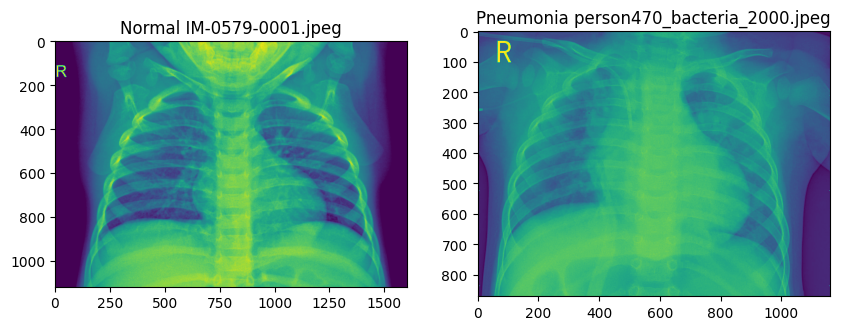

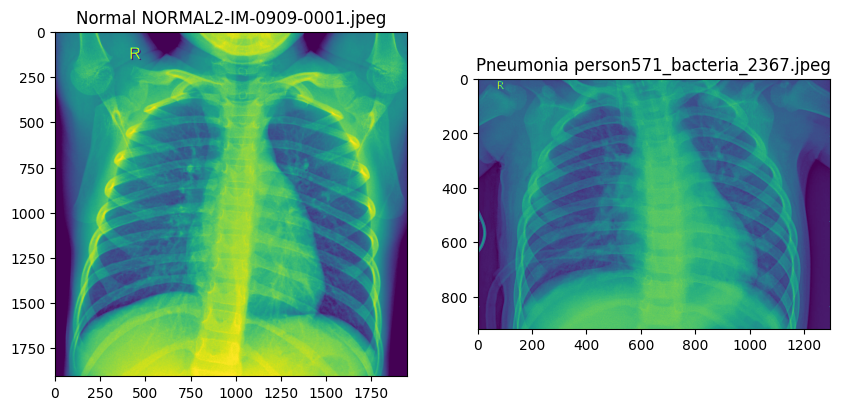

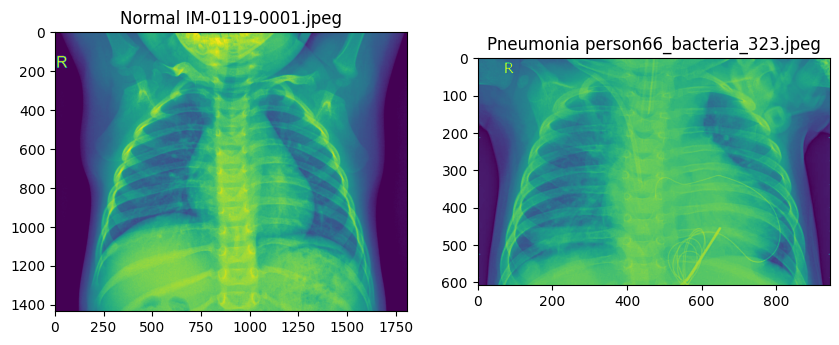

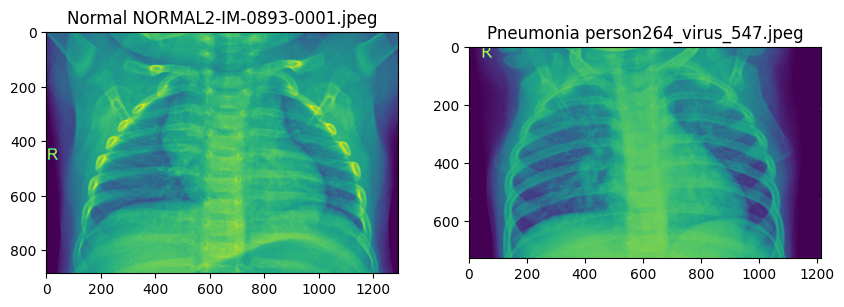

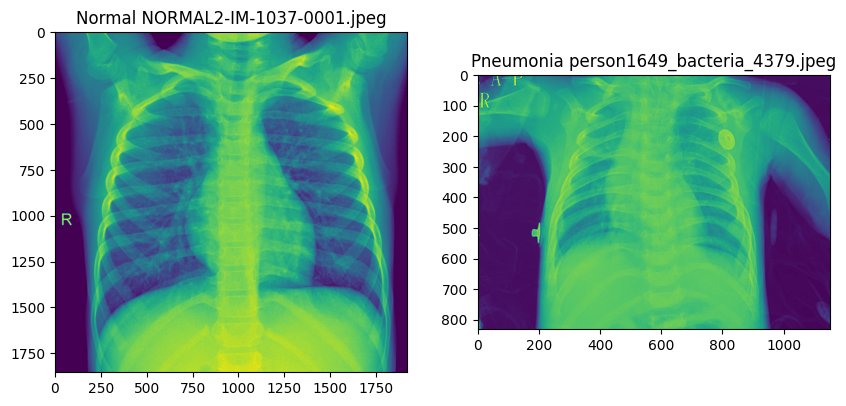

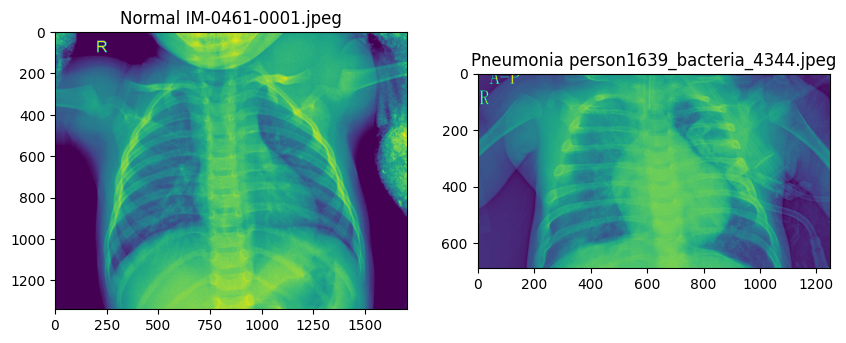

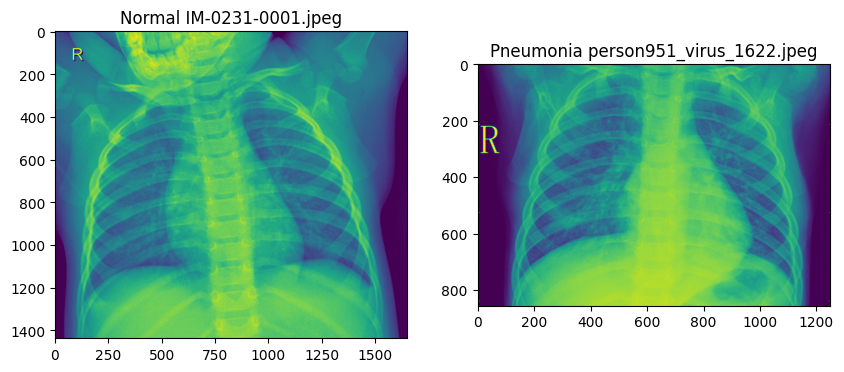

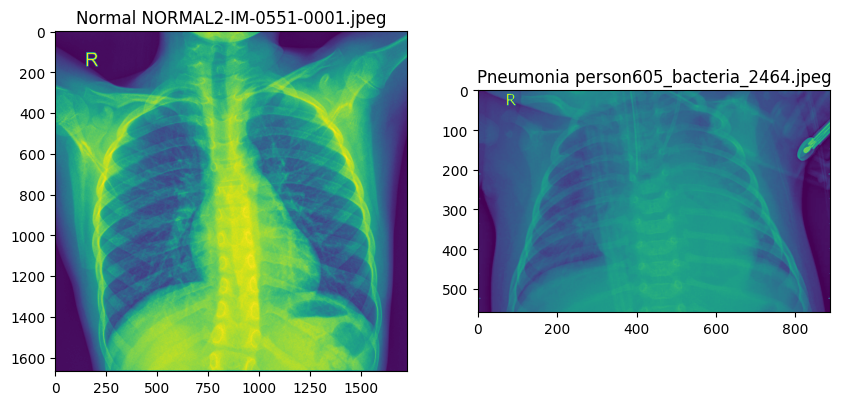

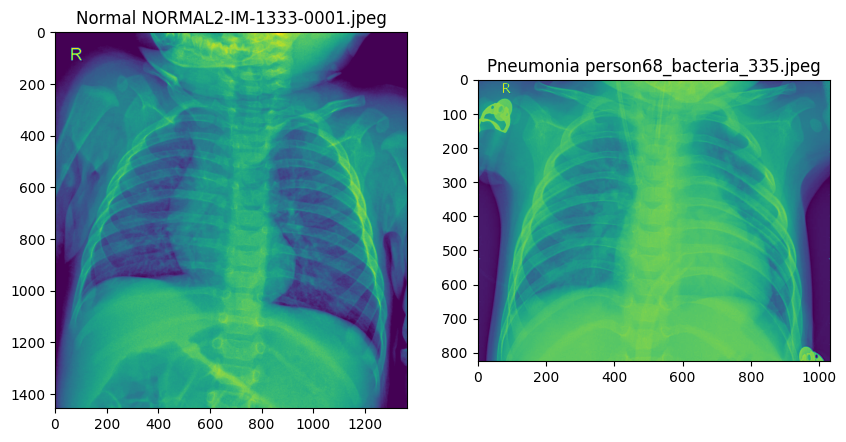

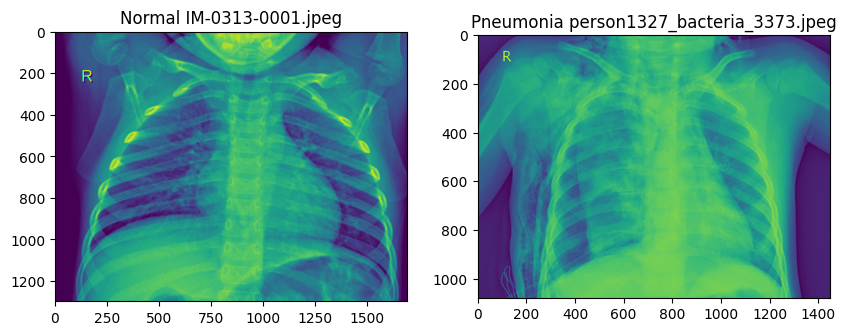

In [ ]:
# Set up folders for normal cases and pneumonia cases wihtin our train data
train_n = train_data_dir + '/NORMAL/'
train_p = train_data_dir + '/PNEUMONIA/'

# Random normal picture from train set
print(f"Normal X-Rays From Validation Set: {len(os.listdir(train_n))} ")

## Select 10 normal pictures
norm_pic = os.listdir(train_n)[25:35]
norm_pic_address = [train_n + pic for pic in norm_pic]

# Random Pneumonia picture from train set
print(f"Pneumonia X-Rays From Validation Set: {len(os.listdir(train_p))} ")

## Select 10 Pneumonia pictures
pneumonia_pic =  os.listdir(train_p)[40:50]
pneumonia_address = [train_p + pic for pic in pneumonia_pic]

for i in range(0,10):
    # Load the images
    norm_img = Image.open(norm_pic_address[i])
    pneumonia_img = Image.open(pneumonia_address[i])

    #Let's plt these images
    ## plot normal picture
    f = plt.figure(figsize= (10,6))
    a1 = f.add_subplot(1,2,1)
    img_plot = plt.imshow(norm_img)
    a1.set_title(f'Normal {norm_pic[i]}')

    ## plot pneumonia picture
    a2 = f.add_subplot(1, 2, 2)
    img_plot = plt.imshow(pneumonia_img)
    a2.set_title(f'Pneumonia {pneumonia_pic[i]}')

In [ ]:
#  Create a data augmentor
data_augmentor = ImageDataGenerator(samplewise_center=True, rescale=1./255, shear_range=0.2,zoom_range = 0.2,samplewise_std_normalization=True,validation_split=0.2)

# Set hyperparameters
target_size = (128,128)
target_dims = (128, 128, 3) # add channel for RGB
n_batch_size = 32

# Create datasets
train_generator = data_augmentor.flow_from_directory(train_data_dir,  target_size=target_size, subset='training',batch_size= n_batch_size,class_mode='binary')
val_generator = data_augmentor.flow_from_directory(train_data_dir, target_size=target_size,subset='validation',class_mode='binary')
test_generator = data_augmentor.flow_from_directory(test_data_dir, target_size=target_size,batch_size= 1,class_mode=None, shuffle=False)

Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
def initialize_model(name):
    model = Sequential(name=name)

    model.add(layers.Conv2D(32, (3, 3), activation="relu", input_shape=target_dims, padding='same'))
    model.add(layers.MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.1))

    model.add(layers.Conv2D(64, (3, 3), activation="relu", padding='same'))
    model.add(layers.MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.1))

    model.add(layers.Conv2D(128, (3, 3), activation="relu", padding='same'))
    model.add(layers.MaxPool2D(pool_size=(3, 3)))
    model.add(Dropout(0.1))

    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

In [ ]:
model = initialize_model(name="basemodel")
model.summary()

Model: "basemodel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 64, 64, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 32, 32, 64)        0 

In [ ]:
def compile_model(model):
    model.compile(optimizer="adam",loss='binary_crossentropy',metrics="binary_accuracy")
    return model

In [ ]:
model_baseline = initialize_model(name="baseline")
history_baseline = compile_model(model_baseline)

callback = [EarlyStopping(patience=5, monitor='val_accuracy', restore_best_weights=True),
            ReduceLROnPlateau(monitor = 'val_loss', patience = 2, factor=0.5, verbose=1),
            ModelCheckpoint("xray_model_v2.h5",save_best_only=True)]

In [ ]:
history_baseline = model_baseline.fit(train_generator,
                                      batch_size=n_batch_size,
                                      epochs=10,
                                      validation_data=val_generator,shuffle=True,
                                      callbacks=callback) #,class_weight=class_weights)

Epoch 1/10
131/131 [==============================] - ETA: 0s - loss: 0.3347 - binary_accuracy: 0.8555

131/131 [==============================] - 278s 2s/step - loss: 0.3347 - binary_accuracy: 0.8555 - val_loss: 0.2158 - val_binary_accuracy: 0.9204 - lr: 0.0010
Epoch 2/10
131/131 [==============================] - ETA: 0s - loss: 0.1945 - binary_accuracy: 0.9240

131/131 [==============================] - 261s 2s/step - loss: 0.1945 - binary_accuracy: 0.9240 - val_loss: 0.1837 - val_binary_accuracy: 0.9166 - lr: 0.0010
Epoch 3/10
131/131 [==============================] - ETA: 0s - loss: 0.1624 - binary_accuracy: 0.9387

131/131 [==============================] - 271s 2s/step - loss: 0.1624 - binary_accuracy: 0.9387 - val_loss: 0.1294 - val_binary_accuracy: 0.9521 - lr: 0.0010
Epoch 4/10
131/131 [==============================] - ETA: 0s - loss: 0.1645 - binary_accuracy: 0.9396

131/131 [==============================] - 265s 2s/step - loss: 0.1645 - binary_accuracy: 0.9396 - val_loss: 0.1663 - val_binary_accuracy: 0.9367 - lr: 0.0010
Epoch 5/10
131/131 [==============================] - ETA: 0s - loss: 0.1348 - binary_accuracy: 0.9511


Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
131/131 [==============================] - 292s 2s/step - loss: 0.1348 - binary_accuracy: 0.9511 - val_loss: 0.1515 - val_binary_accuracy: 0.9492 - lr: 0.0010
Epoch 6/10
131/131 [==============================] - ETA: 0s - loss: 0.1098 - binary_accuracy: 0.9629

131/131 [==============================] - 285s 2s/step - loss: 0.1098 - binary_accuracy: 0.9629 - val_loss: 0.1310 - val_binary_accuracy: 0.9492 - lr: 5.0000e-04
Epoch 7/10
131/131 [==============================] - ETA: 0s - loss: 0.1129 - binary_accuracy: 0.9600


Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
131/131 [==============================] - 286s 2s/step - loss: 0.1129 - binary_accuracy: 0.9600 - val_loss: 0.1427 - val_binary_accuracy: 0.9473 - lr: 5.0000e-04
Epoch 8/10
131/131 [==============================] - ETA: 0s - loss: 0.1079 - binary_accuracy: 0.9607

131/131 [==============================] - 288s 2s/step - loss: 0.1079 - binary_accuracy: 0.9607 - val_loss: 0.1175 - val_binary_accuracy: 0.9569 - lr: 2.5000e-04
Epoch 9/10
131/131 [==============================] - ETA: 0s - loss: 0.0984 - binary_accuracy: 0.9629

131/131 [==============================] - 277s 2s/step - loss: 0.0984 - binary_accuracy: 0.9629 - val_loss: 0.0931 - val_binary_accuracy: 0.9645 - lr: 2.5000e-04
Epoch 10/10
131/131 [==============================] - ETA: 0s - loss: 0.0899 - binary_accuracy: 0.9672

131/131 [==============================] - 283s 2s/step - loss: 0.0899 - binary_accuracy: 0.9672 - val_loss: 0.1054 - val_binary_accuracy: 0.9597 - lr: 2.5000e-04


In [ ]:
scores = model_baseline.evaluate(val_generator)
scores

33/33 [==============================] - 28s 809ms/step - loss: 0.1003 - binary_accuracy: 0.9664


[0.10033396631479263, 0.9664429426193237]

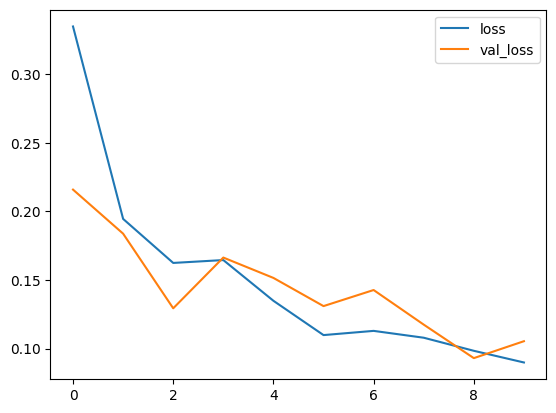

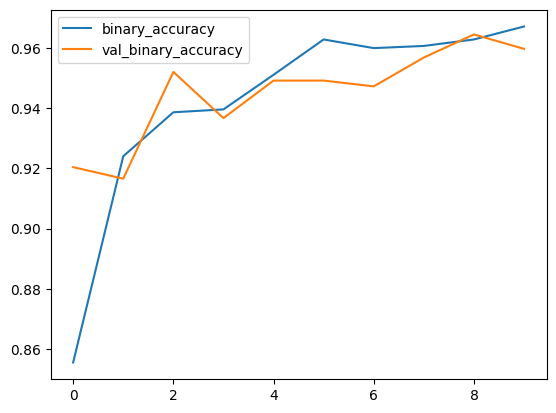

In [ ]:
history_frame = pd.DataFrame(history_baseline.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();

In [ ]:
model.save("model.h5")

In [ ]:
import os

# folder path
dir_path = r'/content/chest-xray-pneumonia/chest_xray/train/NORMAL'
count_train_n = 0
# Iterate directory
for path in os.listdir(dir_path):
    # check if current path is a file
    if os.path.isfile(os.path.join(dir_path, path)):
        count_train_n += 1
print('File count:', count_train_n)

File count: 1341


In [ ]:
import os

# folder path
dir_path = r'/content/chest-xray-pneumonia/chest_xray/train/PNEUMONIA'
count_train_p = 0
# Iterate directory
for path in os.listdir(dir_path):
    # check if current path is a file
    if os.path.isfile(os.path.join(dir_path, path)):
        count_train_p += 1
print('File count:', count_train_p)

File count: 3875


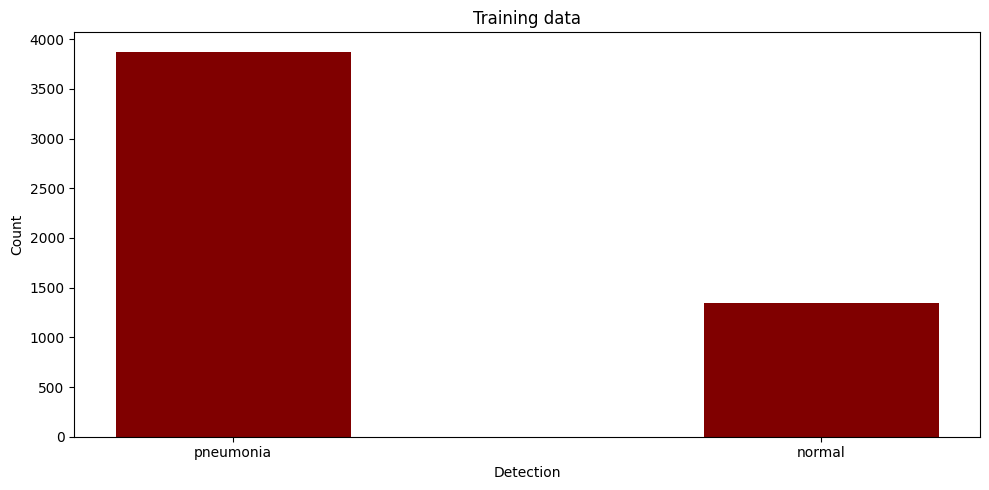

In [ ]:
data = {'pneumonia':count_train_p, 'normal':count_train_n}
courses = list(data.keys())
values = list(data.values())

fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(courses, values, color ='maroon',
        width = 0.4)

plt.xlabel("Detection")
plt.ylabel("Count")
plt.title("Training data")
plt.show()

In [ ]:
import os

# folder path
dir_path = r'/content/chest-xray-pneumonia/chest_xray/test/NORMAL'
count_test_n = 0
# Iterate directory
for path in os.listdir(dir_path):
    # check if current path is a file
    if os.path.isfile(os.path.join(dir_path, path)):
        count_test_n += 1
print('File count:', count_test_n)

File count: 234


In [ ]:
import os

# folder path
dir_path = r'/content/chest-xray-pneumonia/chest_xray/test/PNEUMONIA'
count_test_p = 0
# Iterate directory
for path in os.listdir(dir_path):
    # check if current path is a file
    if os.path.isfile(os.path.join(dir_path, path)):
        count_test_p += 1
print('File count:', count_test_p)

File count: 390


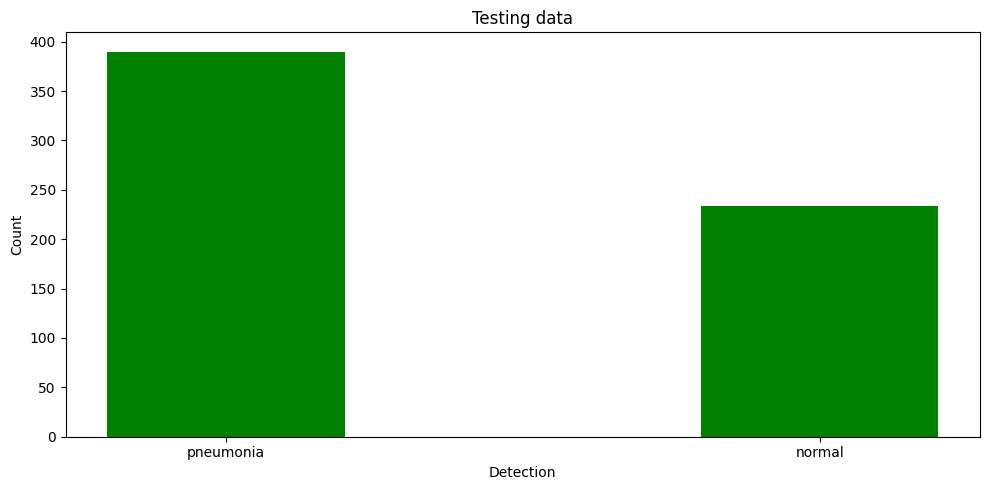

In [ ]:
data = {'pneumonia':count_test_p, 'normal':count_test_n}
courses = list(data.keys())
values = list(data.values())

fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(courses, values, color ='green',
        width = 0.4)

plt.xlabel("Detection")
plt.ylabel("Count")
plt.title("Testing data")
plt.show()

In [ ]:
import os

# folder path
dir_path = r'/content/chest-xray-pneumonia/chest_xray/val/NORMAL'
count_val_n = 0
# Iterate directory
for path in os.listdir(dir_path):
    # check if current path is a file
    if os.path.isfile(os.path.join(dir_path, path)):
        count_val_n += 1
print('File count:', count_val_n)

File count: 8


In [ ]:
import os

# folder path
dir_path = r'/content/chest-xray-pneumonia/chest_xray/val/PNEUMONIA'
count_val_p = 0
# Iterate directory
for path in os.listdir(dir_path):
    # check if current path is a file
    if os.path.isfile(os.path.join(dir_path, path)):
        count_val_p += 1
print('File count:', count_val_p)

File count: 8


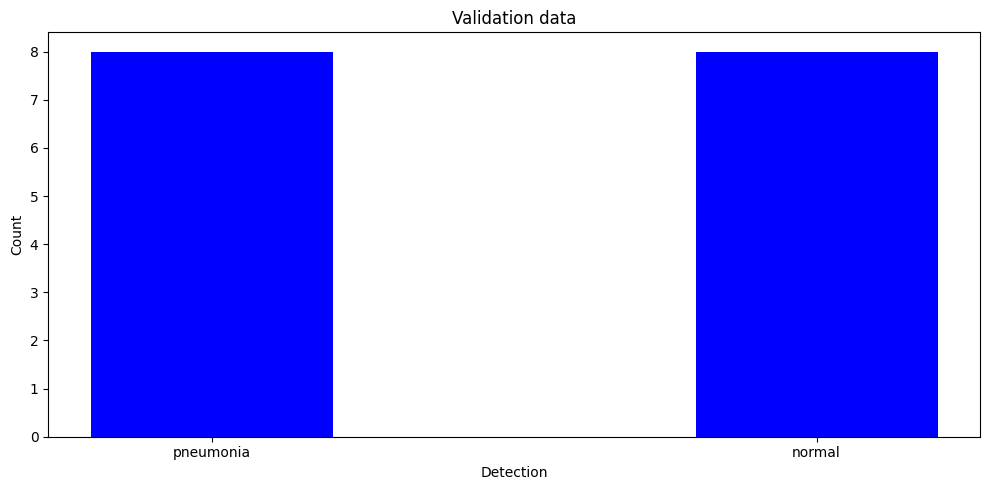

In [ ]:
data = {'pneumonia':count_val_p, 'normal':count_val_n}
courses = list(data.keys())
values = list(data.values())

fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(courses, values, color ='blue',
        width = 0.4)

plt.xlabel("Detection")
plt.ylabel("Count")
plt.title("Validation data")
plt.show()